In [1]:
# Dependencies for plotting charts.
%matplotlib inline
from matplotlib import style
style.use("fivethirtyeight")
import matplotlib.pyplot as plt

In [2]:
# Dependencies which will help deal with arrays, dataframes, and datetime structures respectively. 
import numpy as np
import pandas as pd
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper Dependencies.
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [4]:
# Creates a engine to the hawaii.sqlite database (saved in Resources directory).
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# Reflects an existing database into a new model.
base = automap_base()
# Reflects the tables from the hawaii.sqlite database.
base.prepare(autoload_with=engine)

In [6]:
# Views all of the classes that automap found in the hawaii.sqlite database.
base.classes.keys()

['measurement', 'station']

In [7]:
# Saves references to each table found.
measurement = base.classes.measurement
station = base.classes.station

In [8]:
# Creates session (link) from Python to the DB.
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Displays the column names and their data types for the measurement object. 
inspector = inspect(engine)
columns = inspector.get_columns("measurement")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Finds the most recent date in the data set (from the measurement class).
latest_date = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
print(f"The most recent date in the data set is: {latest_date}")

The most recent date in the data set is: 2017-08-23


In [11]:
# Converts latest_date string to a date format (so that it is no longer read as a string).
latest_date = datetime.strptime(latest_date, "%Y-%m-%d")

# Extracts the year, month, and day from latest_date.
latest_year = latest_date.year
latest_month = latest_date.month
latest_day = latest_date.day

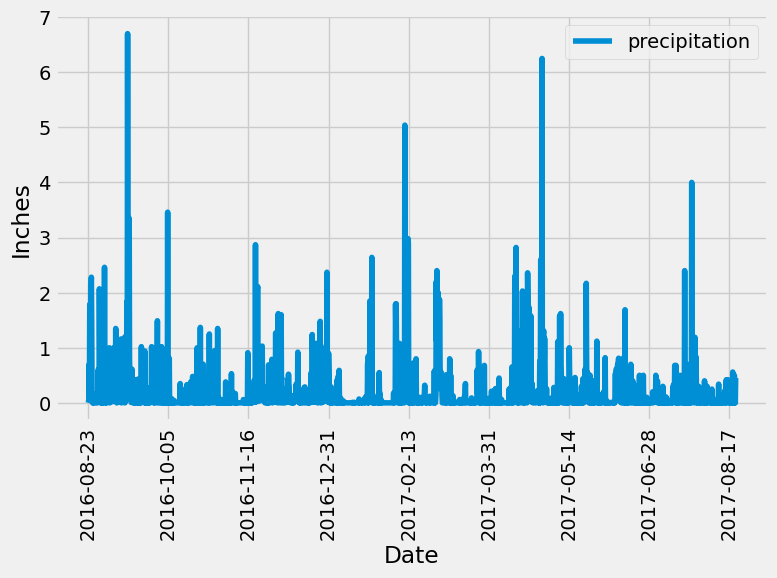

In [12]:
# The below query retrieves the last 12 months of precipitation data and plots the results. 

# The most recent data point in the database in ISO format (ISO stands for International Standard Organisation). 
latest_date = dt.date(latest_year, latest_month, latest_day)

# Calculates the date one year from the last date in the data set.
one_year_prior = latest_date - dt.timedelta(days=365)

# Performs a query to retrieve the dates, and the precipitation scores between the latest date and one year prior.
sel = [measurement.date,
       measurement.prcp]

latest_year_prcp = session.query(*sel).\
                   filter(measurement.date >= one_year_prior).\
                   filter(measurement.date <= latest_date).all()

# Saves the query results as a Pandas DataFrame and explicitly sets the column names.
latest_precipitation_df = pd.DataFrame(latest_year_prcp, columns=["date", "precipitation"])

#Drops N/A rows from the dataframe. 
latest_precipitation_df = latest_precipitation_df.dropna(how ='any')

# Sorts the dataframe by date in ascending order (earliest-latest date).
latest_precipitation_df = latest_precipitation_df.sort_values("date")

# Uses Pandas Plotting (with Matplotlib) to plot the last 12 months of precipitation data.
latest_precipitation_df.plot(x="date", y="precipitation",figsize=(8,6))

plt.xlabel("Date")
plt.ylabel("Inches")
plt.xticks(rotation="vertical")
plt.tight_layout()

In [13]:
# Uses Pandas to calculate the summary statistics for the precipitation data.
latest_precipitation_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Displays the columns names and their data types for the station object. 
inspector = inspect(engine)
columns = inspector.get_columns("Station")
for c in columns:
    print(c["name"], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [15]:
# Calculates the total number of stations in the dataset.
station_count = session.query(func.count(station.station.distinct())).all()[0][0]
print (f"There are {station_count} stations in this dataset.")

There are 9 stations in this dataset.


In [30]:
q = session.query(station.station).\
        outerjoin(measurement, station.station == measurement.station).\
        filter(measurement.station == None).all()

q

[]

In [16]:
# Finds the most active stations (i.e. which stations have the most rows).
# Stations and their counts are listed in descending order.
station_activity = session.query(measurement.station, func.count(measurement.station)).\
              group_by(measurement.station).\
              order_by(func.count(measurement.station).desc()).all()

station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Extracts the most active station string from the above list of tuples.
most_active_station = station_activity[0][0]

print(f"Based on the above findings, station: {most_active_station} has the greatest number of observations\nand is therefore the most active station.")

Based on the above findings, station: USC00519281 has the greatest number of observations
and is therefore the most active station.


In [18]:
# Uses the most active station id from the previous query and calculates its lowest, highest, and average temperature.
# tobs stands for temperature observations. 
active_summary = session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
              filter(measurement.station == most_active_station).all()

print(f"Lowest Tob: {active_summary[0][0]}\nHighest Tob: {active_summary[0][1]}\nAverage Tob: {active_summary[0][2]}")

Lowest Tob: 54.0
Highest Tob: 85.0
Average Tob: 71.66378066378067


In [19]:
# Finds the most recent date in the data set when filtered only to the most active station.
active_latest_date = session.query(measurement.date).\
                           filter(measurement.station == most_active_station).\
                           order_by(measurement.date.desc()).first()[0]
print(f"The most recent date in the data set when filtered to the most active station is: {active_latest_date}")

The most recent date in the data set when filtered to the most active station is: 2017-08-18


In [20]:
# Converts active_latest_date string to a date format.
active_latest_date = datetime.strptime(active_latest_date, "%Y-%m-%d")

# Extracts the year, month, and day from active_latest_date.
active_latest_year = active_latest_date.year
active_latest__month = active_latest_date.month
active_latest_day = active_latest_date.day

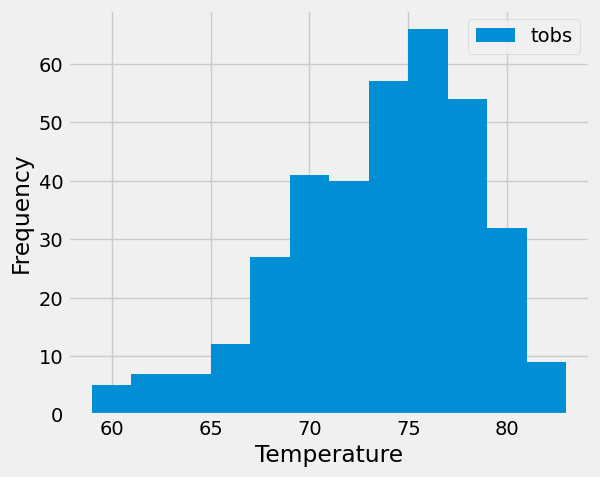

In [21]:
# The most recent data point in the database when filtered to the most active station (in ISO format). 
active_latest_date = dt.date(active_latest_year, active_latest__month ,active_latest_day)

# Calculates the date one year from active_latest_date.
active_one_year_prior = active_latest_date - dt.timedelta(days=365)

# Queries the last 12 months of temperature observation data for the most active station and plots the results as a histogram.

active_latest_year_tobs = session.query(measurement.tobs).\
                   filter(measurement.station == most_active_station).\
                   filter(measurement.date >= active_one_year_prior).\
                   filter(measurement.date <= active_latest_date).all()

# Saves the query results as a Pandas DataFrame and explicitly sets the column names.
active_latest_tobs_df = pd.DataFrame(active_latest_year_tobs, columns=["tobs"])

# Histogram plot.
active_latest_tobs_df.plot.hist(bins=12, figsize=(6,5))
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.show()

# Close Session

In [22]:
# Close Session
session.close()